In [29]:
import pandas as pd
import textwrap
from IPython.display import clear_output
import numpy as np
from ipywidgets import Output
import matplotlib.pyplot as plt
import numpy as np
import json 
import preamble
import src.constants as const
from sklearn.metrics import roc_curve

### 1. Sample and rate whether speeches were correctly classified as migration 

In [21]:
# import data
df_topics = pd.read_parquet(const.PATH_ALL_SPEECHES)

In [23]:
topic_id = 19 # Lda topic with top words: refugee, border, migration, migrant, asylum
prob_col = f"topic_{topic_id}"

prob_range = (0.20, 0.35) # based on initial tests, good threshold should lie in this range

n = 100 # number of speeches to sample for manual rating
seed = 43 # both raters should get the same sample

candidates = df_topics[(df_topics[prob_col] >= prob_range[0]) & (df_topics[prob_col] <= prob_range[1])] # speeches within probability range, we will sample from these

sampled = candidates.sample(n=min(n, len(candidates)), random_state=seed).reset_index(drop=True)
ratings = []

rater = "Jakob" # ratings done by two authors, later merged

output_path = f"data/lda/manual_ratings_topic{topic_id}_{rater}.json"
output_path_final = f"data/lda/manual_ratings_topic{topic_id}_merged.json"

In [24]:
print("Sanity check: speech with max topic score\n\t", df_topics[df_topics[prob_col] == (df_topics[prob_col]).max()]["translatedText"].iloc[0])

Sanity check: speech with max topic score
	 I voted in favour of this report. Europe has been paralysed with regard to the migrant crisis. While we keep discussing possible solutions to the grave problem we face, it hardly ever comes to common action. However, even when we do decide on joint measures, we do not follow through on them. The Dublin Agreement and the relocation system have failed utterly, as the Member States have not committed to apply them. We must either effectively enforce the current measures, or introduce new ones. Either way, it is not a problem that can be solved by any Member State alone. It is a dilemma that must be dealt with by the European Union as a whole. It cannot be fixed by closing national borders, but only by guarding our common ones; those defined by Schengen. What we need to do is form a common border guard and coast guard and put a collective reception and relocation system in place. Furthermore, we must prompt Turkey to crack down on the criminals s

In [25]:
def process_response(prompt= "Rate (y, n, q):"): 
    answer = input(prompt)
    if answer == 'q':
        return -1
    elif answer == 'y': 
        return 1
    elif answer == 'n': 
        return 0
    else: 
        return process_response("Try again (y, n, q):")

def get_rating(sampled, index, prob_col):
    row = sampled.iloc[index]

    print(f"Progress: {index}/{len(sampled)} speeches rated")
    print("\n")
    # print(f"\nSpeech {index}/{len(sampled)} | Year: {row['year']} | Party block: {row['block']}")
    print(textwrap.fill(row["translatedText"], width=90))

    return process_response()

In [26]:
# Flag to control the manual rating loop
running = True

# If all speeches are already rated, skip; otherwise start/continue rating
if len(ratings) == len(sampled): 
    print("Ratings are done.")
else: 
    print(f"Starting manual rating: {len(ratings)}/{len(sampled)} speeches to rate.")
    print(f"{'='*90}\n")

    out = Output()
    display(out) 
    with out: 
        # Loop until user quits or all speeches are rated
        while running: 
            clear_output()

            # Determine which speech to rate next
            current_index = len(ratings)
            response = get_rating(sampled, current_index, prob_col)

            # Handle quit command
            if response == -1: 
                clear_output()
                print("Terminated.")
                print("Continue at index", current_index)
                running = False
            else: 
                # Store the rating and continue
                ratings.append(response)

            # Stop when the last speech has been rated
            if current_index >= len(sampled) - 1:
                print(f"Rating complete! Rated {len(ratings)}/{len(sampled)} speeches.")
                # Add ratings to dataframe
                sampled.loc[:len(ratings) - 1, 'rating'] = ratings
                print(f"\nFinal ratings: {ratings}")
                running = False

# Show current ratings list
print(ratings)

Starting manual rating: 0/100 speeches to rate.



Output()

[]


In [ ]:
# save as json
ratings = sampled['rating'].tolist()
probabilities = sampled[prob_col].tolist()

ratings_dict = {
    "ratings": ratings,
    "probabilities": probabilities
}
# json.dump(ratings_dict, open(output_path, "w"))
# print(f"Saved ratings to {output_path}")

Saved ratings to ../../data/lda/manual_ratings_topic19_Jakob.json


### 2. Merge ratings from two authors and process disagreements

In [18]:
RATER_1 = "Quirin"
RATER_2 = "Jakob"
path_ratings1 = f"../../data/lda/manual_ratings_topic{topic_id}_{RATER_1}.json"
path_ratings2 = f"../../data/lda/manual_ratings_topic{topic_id}_{RATER_2}.json"

In [20]:
r1 = json.load(open(path_ratings1, "r"))
r2 = json.load(open(path_ratings2, "r"))

ratings1 = np.array(r1["ratings"])
ratings2 = np.array(r2["ratings"])

probabilities1 = r1["probabilities"]
probabilities2 = r2["probabilities"]
assert probabilities1 == probabilities2, "Probabilities do not match between raters!"

In [ ]:
disagreements = ~(ratings1 == ratings2)
new_ratings = dict()
print("Number of disagreements:", sum(disagreements))

for sample_index, r in sampled[disagreements].iterrows():
    print("Rater 1:", ratings1[sample_index])
    print("Rater 2:", ratings2[sample_index])

    print(textwrap.fill(r["translatedText"], width=90))
    print("="*100)

    response = process_response("Rate again. q to quit, y for keep, n for discard")
    if response == -1: 
        break 
    new_ratings[sample_index] = response
    clear_output()

ratings_merged = ratings1.copy()
for i, new_rating in new_ratings.items():
    ratings_merged[int(i)] = new_rating

In [ ]:
# save ratings merged to json
ratings_dict["ratings_merged"] = ratings_merged.tolist()
# with open(output_path_final, 'w') as f:
#     json.dump(ratings_dict, f)
# print(f"Saved merged ratings to {output_path_final}")

### 3. Determine probability threshold for speeches to be labeled migration based on ratings

In [16]:
ratings_dict = json.load(open(output_path_final))
ratings = ratings_dict["ratings_merged"]
probabilities = ratings_dict["probabilities"]

In [17]:
X = np.array(probabilities).reshape(-1, 1)
y = np.array(ratings)
xs = X.ravel()
ys = y.ravel()

Text(0, 0.5, 'Decision')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the foll

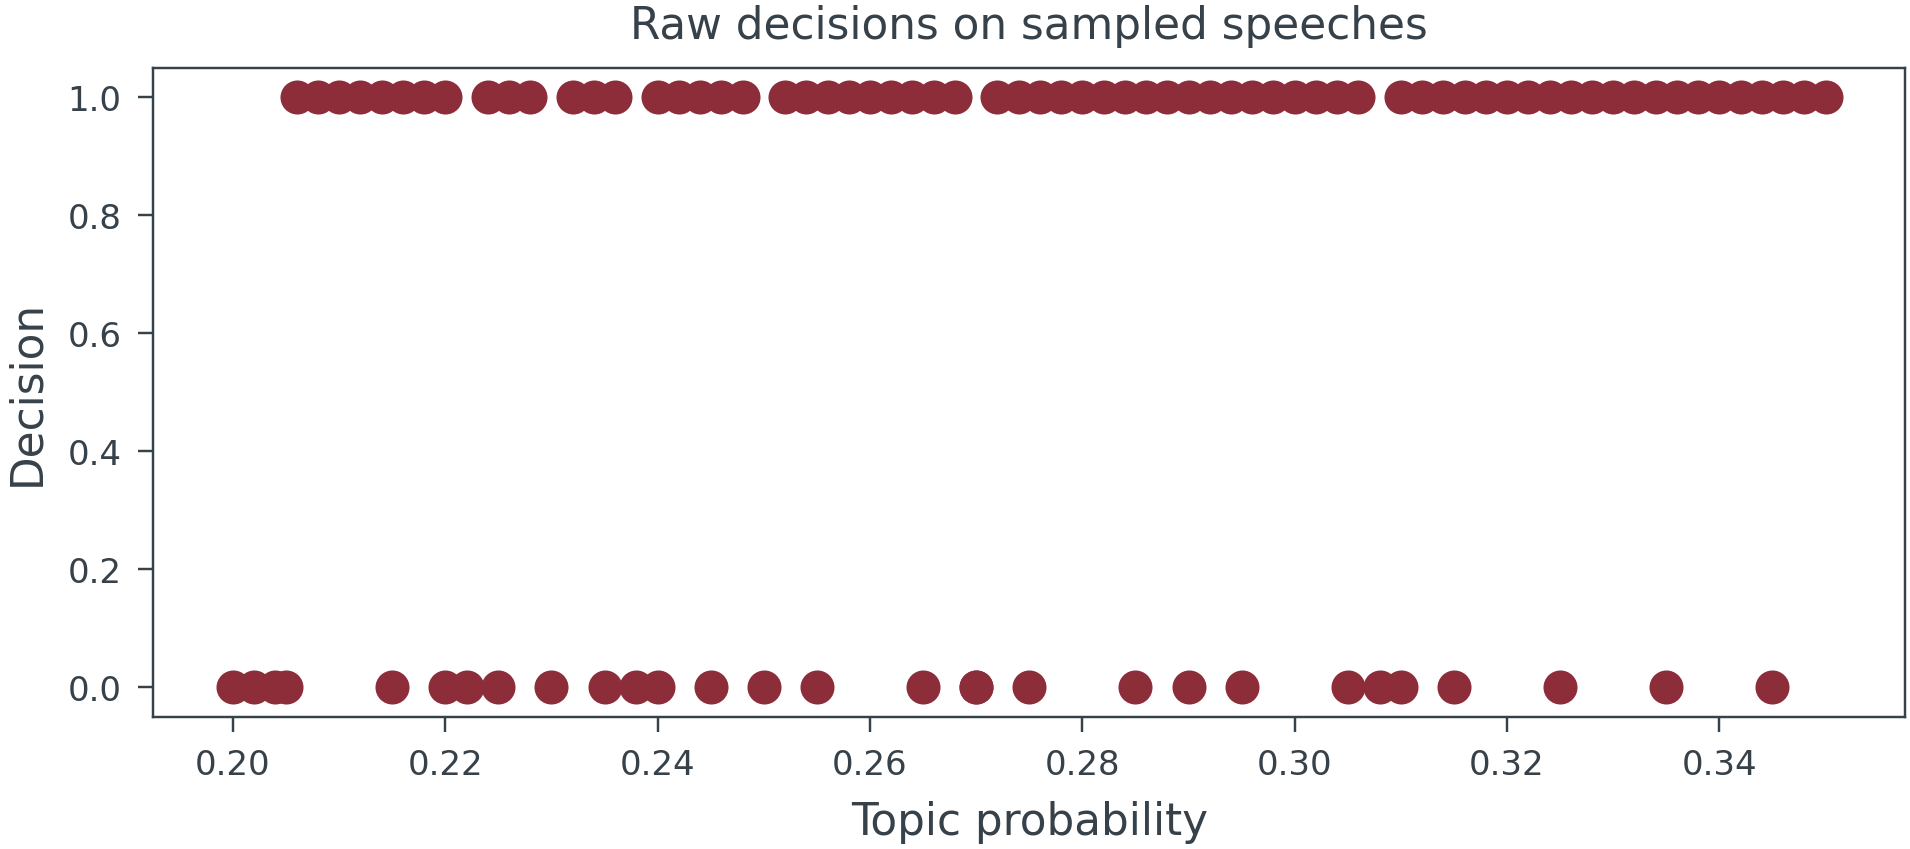

In [30]:
# scatter plot of raw binary decisions
plt.plot(X, y, 'o')
plt.title("Raw decisions on sampled speeches")
plt.xlabel("Topic probability")
plt.ylabel("Decision")

findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the foll

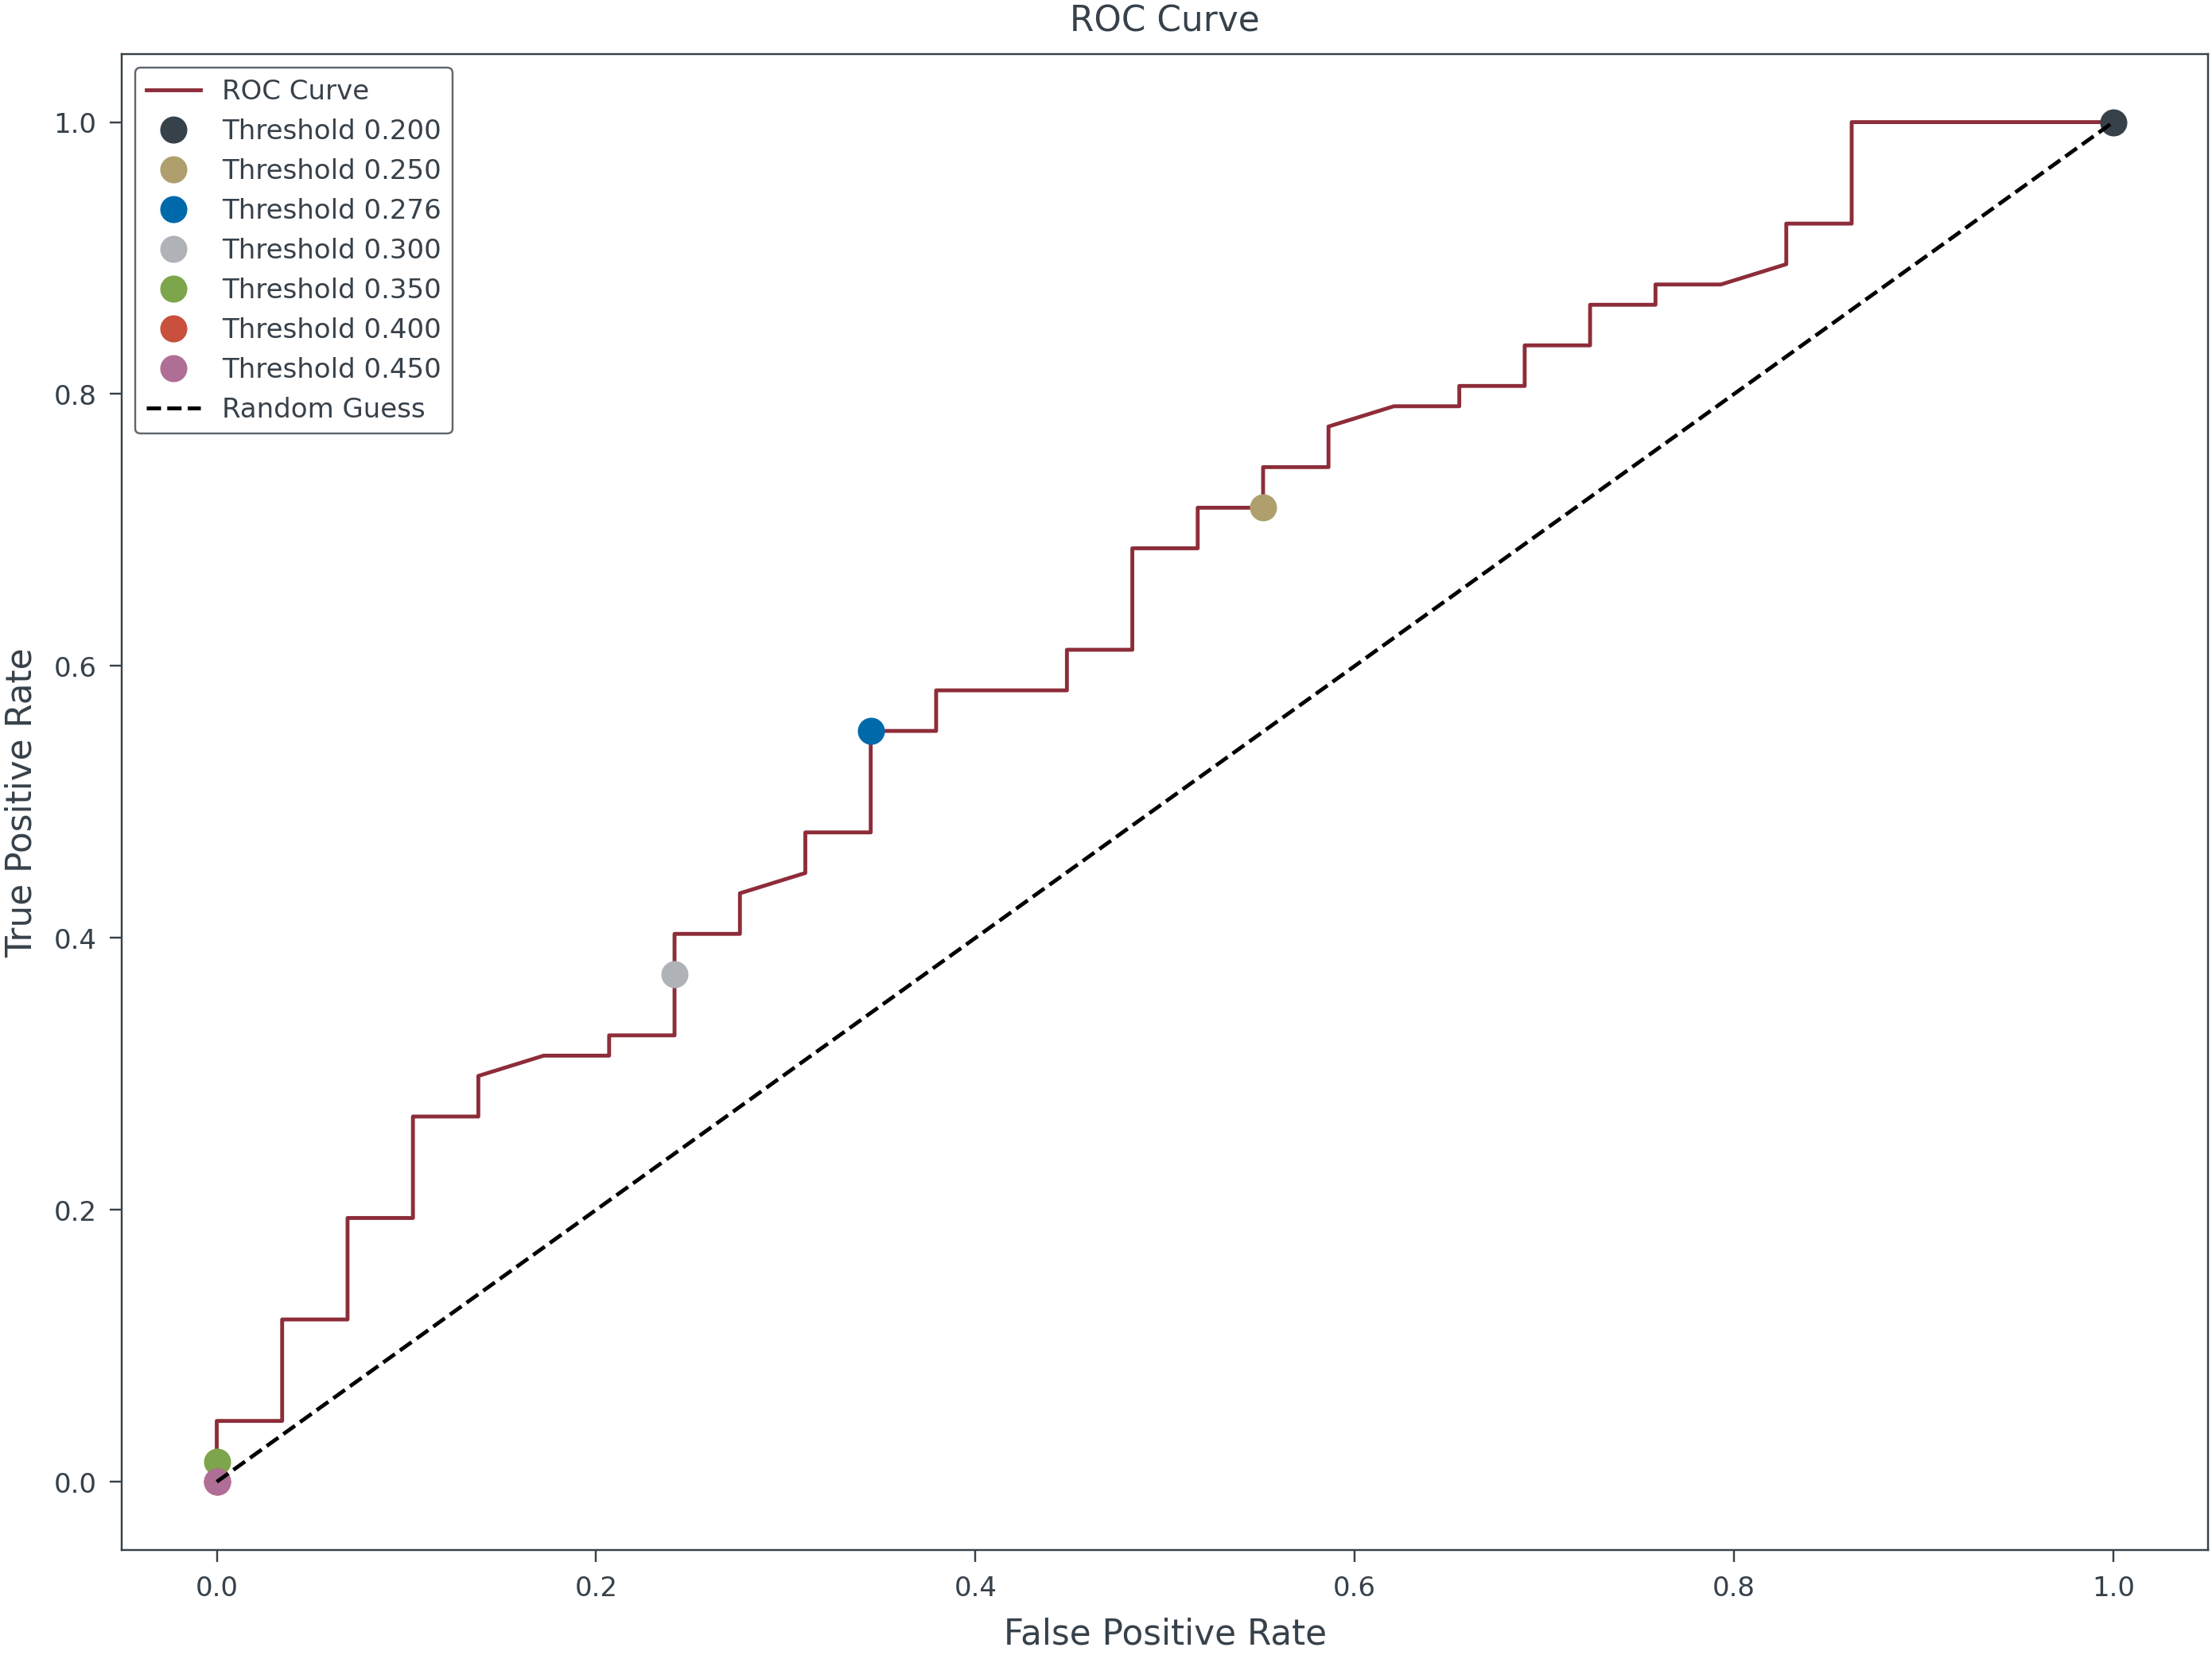

Optimal threshold using ROC curve: 0.2760


In [19]:
# use ROC curve to find optimal threshold
fpr, tpr, thresholds = roc_curve(y, X)
best = np.argmax(tpr - fpr) # difference between true positive rate and false positive rate
threshold = thresholds[best] 
# plot ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y, X)
plt.plot(fpr, tpr, label='ROC Curve')
# plot points for regular intervals of potential thresholds, plus the  optimal one
for thresh in sorted([threshold, *np.arange(0.2, 0.5, 0.05)]): 
    pred = (xs >= thresh).astype(int)
    fpr = np.sum((pred == 1) & (ys == 0)) / np.sum(ys == 0) # false positive rate under current threshold
    tpr = np.sum((pred == 1) & (ys == 1)) / np.sum(ys == 1) # true positive rate under current threshold
    plt.plot(fpr, tpr, 'o', label=f'Threshold {thresh:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
print(f"Optimal threshold using ROC curve: {threshold:.4f}")